In [1]:
import os
import librosa
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader

In [3]:
class MyDataset(Dataset):
    def __init__(self,train=True):
        self.train = train
        self.root = 'aug_data/'
        if train:
            self.wave_list = os.listdir(self.root+'train/')
            self.train_targets = pd.read_csv('data/train_answer.csv').drop(['id'],axis=1).values
        else:
            self.wave_list = os.listdir(self.root+'test/')

    def __getitem__(self,index):
        if self.train:
            x_root = self.wave_list[index]
            target = self.train_targets[int(x_root.split('_')[0])]

            x = torch.load(self.root+'train/'+x_root)
            y = torch.tensor(target,dtype=torch.float32)
            return x,y
        else:
            x_root = self.wave_list[index]
            x = torch.load(self.root+'test/'+x_root)
            return x
            
    def __len__(self):
        return len(self.wave_list)

In [7]:
dataset = MyDataset()

train_ratio = 0.7
train_size = int(len(dataset)*train_ratio)
val_size = len(dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(dataset,[train_size,val_size])
batch_size = 2**9
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=train_dataset, batch_size=500)

In [8]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.elu = nn.ELU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.elu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.elu = nn.ELU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 32, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(11264, 30)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        out = self.conv(x)
        out = self.bn(out)
        out = self.elu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.softmax(self.fc(out))
        return out

In [9]:
cuda_use = True
resnet = ResNet(ResidualBlock, [3, 3, 3])
print('# of parameters = ',sum(p.numel() for p in resnet.parameters()))

if cuda_use and torch.cuda.is_available():
    resnet.cuda()
optimizer = optim.Adam(params=resnet.parameters(),lr=1e-3)

# of parameters =  473134


In [10]:
plot_list = {'train':[],'val':[]}
time_list = [time.time()]


resnet.load_state_dict(torch.load('resnet_state_dict.pth'))

for epoch in range(200):
    """
    학습 및 검증
    """
    resnet.train()
    train_losses = []
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs, targets = inputs.cuda(),targets.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = resnet(inputs)
        train_loss = nn.KLDivLoss(reduction='batchmean')(outputs.log(),targets)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.detach())

        del inputs
        del targets
        del outputs
        del train_loss
        
    resnet.eval()
    val_losses = []
    for data in val_loader:
        inputs, targets = data
        inputs, targets = inputs.cuda(),targets.cuda()

        outputs = resnet(inputs)
        val_loss = nn.KLDivLoss(reduction='batchmean')(outputs.log(),targets)
        val_losses.append(val_loss.detach())
        
        del inputs
        del targets
        del outputs
    

    time_list.append(time.time())
    print(f"{epoch+1} time = {(time_list[-1]-time_list[-2])/60} minutes")
    print(f"{epoch+1} epoch train loss = {sum(train_losses)/len(train_losses)}")
    print(f"{epoch+1} epoch val loss = {sum(val_losses)/len(val_losses)}")
    print('--------------------------------------------------')
    plot_list['train'].append(sum(train_losses)/len(train_losses))
    plot_list['val'].append(sum(val_losses)/len(val_losses))
    
    """
    early stopping
    patience=5
    """
    
    current_val_loss = sum(val_losses)/len(val_losses)
    min_val_loss = min(plot_list['val'])
    patience = 10
    
    if current_val_loss <= min_val_loss:
        min_loss_model = resnet
        current_patience = 0
    else:
        current_patience+=1
        if current_patience == patience:
            resnet = min_loss_model
            torch.save(resnet.state_dict(), 'resnet_state_dict.pth')
            break
print('Finished Training')

/home/tactics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1 time = 8.718628613154094 minutes
1 epoch train loss = 1.100798487663269
1 epoch val loss = 1.070715069770813
--------------------------------------------------
2 time = 8.724307556947073 minutes
2 epoch train loss = 1.0704313516616821
2 epoch val loss = 1.0337635278701782
--------------------------------------------------
3 time = 8.725085310141246 minutes
3 epoch train loss = 1.052371859550476
3 epoch val loss = 1.0161831378936768
--------------------------------------------------


KeyboardInterrupt: 

In [9]:
resnet.load_state_dict(torch.load('resnet_state_dict.pth'))

<All keys matched successfully>

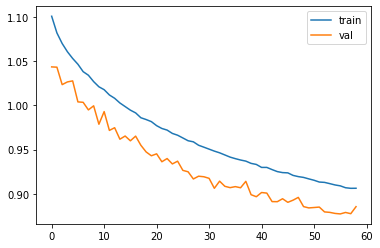

In [10]:
plt.plot(plot_list['train'],label='train')
plt.plot(plot_list['val'],label='val')
plt.legend()
plt.show()

In [11]:
resnet.cpu()
submission = pd.read_csv('data/submission.csv', index_col=0)
test_dataset = MyDataset(train=False)
test_loader = DataLoader(test_dataset,batch_size=1)

In [12]:
for i,x in zip(test_dataset.wave_list,test_dataset):
    submission.loc[int(i.split('.')[0])] = resnet(x.unsqueeze(0)).tolist()[0]

/home/tactics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
submission.to_csv('resnet_5.csv')